## 8 - Exploratory Factor Analysis
### Finding latent variables in data

We now start to move from the traditional modelling framework of using some variables to predict another, and into the realm of exploratory factor analysis (EFA). EFA is a *multivariate* technique which means that it has no clear distinction on what a 'predictor' or an 'outcome' variable is - rather, the aim of EFA is to take a set of variables and find another set of variables that represent the original ones. These are the so-called **latent** variables that, under the EFA model, are assumed to "give rise" to the original set of variables.

EFA is commonly used to distil psychological constructs from things like questionnaire data. A popular example in psychology of this is the Big Five personality traits, which emerge from EFA of people rating adjectives about personalities to the extent they feel that are like that - e.g. "outgoing", "anxious".

The key thing to remember is that EFA is also a linear model. You can think about it from the following somewhat quirky perspective - what an EFA does is takes each of your original variables, and tries to come up with a set of predictor variables that predicts each original variable well. It has to do that simultaneously for each of the original variables - so its really just coming up with a set of variables that 'best explain' all the observed variables at once!

Lets see how we can fit one in Python. To do so, we'll use a new package, the `factor_analyzer` package, which has a model called `FactorAnalyzer`. Below we import a few key things as well as the new module.

In [1]:
# Import what we need
import pandas as pd # dataframes
import seaborn as sns # plots
import statsmodels.formula.api as smf # Models
import marginaleffects as me # marginal effects
import numpy as np # numpy for some functions
import pingouin as pg
from factor_analyzer import FactorAnalyzer # Note we write from factor_analyzer


To examine this idea, we'll rely on a classic idea - that of the *g* factor of intelligence. The dataset below is taken from JASP's examples and comes from Spearman (1908) himself. It represents a set of scores on the following variables for a group of students:

- Pitch - Score in pitch discrimination test.
- Light - Score in light discrimination test.
- Weight - Score in weight discrimination test.
- Classics - School grade for classic studies.
- French - School grade for French.
- English - School grade for English.
- Mathematics - School grade for mathematics.

We can read in the data from the following link, then look at the top 5 rows. https://raw.githubusercontent.com/alexjonesphd/py4psy2024/refs/heads/main/G%20Factor.csv

In [2]:
# Read in data
g = pd.read_csv('https://raw.githubusercontent.com/alexjonesphd/py4psy2024/refs/heads/main/G%20Factor.csv')
g.head(5)

,Pitch,Light,Weight,Classics,French,English,Mathematics
0,50,10,4,16,19,10,7
1,3,10,6,5,6,6,5
2,10,10,6,5,6,6,5
3,60,10,9,22,23,22,22
4,4,12,5,1,1,1,2


Our goal is to find the underlying *g* variable - that is, 'intelligence' - a latent variable that gives rise to all of the scores we see across the tests. We do this by making a `FactorAnalyzer` model and fitting it to the data. Notice a key thing here - we deliberately set the number of factors to 1. This is a crucial consideration. In EFA you *must* specify the number of factors you want to see *before you start!*

In [3]:
# Build and fit an EFA with a single factor
efa = FactorAnalyzer(n_factors=1).fit(g)

/opt/miniconda3/envs/py11/lib/python3.11/site-packages/factor_analyzer/factor_analyzer.py:663: UserWarning: No rotation will be performed when the number of factors equals 1.


With this single model, there are many things to inspect to understand the overall result. Let's take a look at them!

### Factor Loadings
The first key bit of information is how the original variables correlate with the discovered factor(s). In our example with *g*, we will see how each individual test correlates with the general measure of intelligence. These are often referred to as 'factor loadings', but don't let the term confuse you - they are correlations of the original variables with the discovered latent variables. We can obtain them from the `.loadings` attribute; here put into a dataframe to look nicer.

In [4]:
# Obtain loadings
g_loadings = pd.DataFrame(efa.loadings_,
                          columns=['g_factor'],
                          index=g.columns)

g_loadings

,g_factor
Pitch,0.220054
Light,0.162702
Weight,0.094585
Classics,0.975240
French,0.939743
English,0.833758
Mathematics,0.911261


This illustrates scores on mathematics, classics, and French tests are all *very* strongly correlated with the discovered factor. Conversely, the weight and light tests are poorly correlated. That is, the general intelligence variable does not influence them much.

**Convention suggests that if a variable has a correlation with a factor of greater than .4 or less than -.4, it is "loaded" on that factor**.

### Factor variances
Another important bit of information EFA gives us is the *explained variance* of the factors. The latent variables will, depending on the data and number of them, do a more or less good job of explaining th variance in the *original variables*. 

We can obtain these from our models `.get_factor_variance()` method, which returns a list of three types - variance of factors (less useful), variance due to each factor (very handy) and cumulative variance. In our case here there is only one value, but later examples will see more factors and thus more variance.

In [5]:
# Get factor variances
efa.get_factor_variance() 
# 1. Variance of each factor
# 2. Amount of variance each factor is responsible for in the data
# 3. The cumulative variance across the factors

(array([3.44360164]), array([0.49194309]), array([0.49194309]))

### Communalities
This is another example of statisticians using weird words to describe a concept we already know about. Each original variable has a 'communality' value - this is simply the amount of variance the factors explain in that variable - remember, an EFA is 'figuring out' the *predictors* of a regression for each of the variables. A good EFA model has high communalities for all variables, typically above .7. In using EFA to build psychometric tests we might drop questions with low communalities. We get communalities like so:

In [6]:
# Get communalities
comms = pd.DataFrame(efa.get_communalities(), columns=['communality'], index=g.columns)
comms

,communality
Pitch,0.048424
Light,0.026472
Weight,0.008946
Classics,0.951093
French,0.883117
English,0.695152
Mathematics,0.830397


These look OK for classics, french and mathematics, but poorer for the others - in this simple case the interpretation is similar to the loadings we saw earlier.

### The latent factors themselves
Finally, if we want to, we can obtain an actual estimate of the latent variable itself from the model. This is useful to examine or to even perhaps include in another model. We do this by asking our EFA model to `transform` the original data, whereupon we get a representation of the latent variable(s). In this case, we obtan scores on *g*, which look like a Z-scored variable, with higher numbers indicating more intelligence.

In [7]:
# Obtain latent scores
latent = efa.transform(g)

# Put it in a dataframe
latent = pd.DataFrame(latent, columns=['g_factor'])
latent

,g_factor
0,0.255022
1,-1.004152
2,-1.011543
3,1.510647
4,-1.594142
5,-1.303185
6,0.282946
7,1.690320
8,-0.255428
9,-1.250707


### Psychometrics and EFA
A common use case for EFA is in the developmental of psychometric tests or questionnaires. Researchers can use EFA uncover a latent set of dimensions underpinning responses to a questionnaire. In this way they can refine the test by dropping some items, including more, or establishing how many 'things' their test is measuring (i.e. is it measuring 5 aspects of personality, or a single construct like intelligence?).

Lets see an example of a larger dataset with more than one latent factor - specifically, the Big Five personality variables. This dataset contains responses from 2,800 people on the Big Five Inventory, a questionnaire measuring personality. There are 25 questions, each asking the person to say how much they agree with a particular statement. The EFA model thus assumes there are several latent variables that give rise to peoples responses on these questions, and our aim is to find them.

The specific questions are available [here](https://vincentarelbundock.github.io/Rdatasets/doc/psych/bfi.html), along with the data at this link: https://vincentarelbundock.github.io/Rdatasets/csv/psych/bfi.csv

First, we can read it in and display it. If you take a closer look at the columns, you can see there are five questions for each trait, with each question denoted by an initial and a number, e.g. E1 is the first question measuring Extraversion, O2 the second for Openness, and so on.

In [8]:
# Big five data
bf = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/psych/bfi.csv')
bf.head(5)

,rownames,A1,A2,A3,A4,A5,C1,C2,C3,C4,...,N4,N5,O1,O2,O3,O4,O5,gender,education,age
0,61617,2.0,4.0,3.0,4.0,4.0,2.0,3.0,3.0,4.0,...,2.0,3.0,3.0,6,3.0,4.0,3.0,1,NaN,16
1,61618,2.0,4.0,5.0,2.0,5.0,5.0,4.0,4.0,3.0,...,5.0,5.0,4.0,2,4.0,3.0,3.0,2,NaN,18
2,61620,5.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,2.0,...,2.0,3.0,4.0,2,5.0,5.0,2.0,2,NaN,17
3,61621,4.0,4.0,6.0,5.0,5.0,4.0,4.0,3.0,5.0,...,4.0,1.0,3.0,3,4.0,3.0,5.0,2,NaN,17
4,61622,2.0,3.0,3.0,4.0,5.0,4.0,4.0,5.0,3.0,...,4.0,3.0,3.0,3,4.0,3.0,3.0,1,NaN,17


We drop the `rownames`, `gender`, `education`, and `age` columns for now.

In [9]:
# Drop the non-required columns
bf2 = bf.drop(columns=['rownames', 'gender', 'education', 'age'])
bf2.head()

,A1,A2,A3,A4,A5,C1,C2,C3,C4,C5,...,N1,N2,N3,N4,N5,O1,O2,O3,O4,O5
0,2.0,4.0,3.0,4.0,4.0,2.0,3.0,3.0,4.0,4.0,...,3.0,4.0,2.0,2.0,3.0,3.0,6,3.0,4.0,3.0
1,2.0,4.0,5.0,2.0,5.0,5.0,4.0,4.0,3.0,4.0,...,3.0,3.0,3.0,5.0,5.0,4.0,2,4.0,3.0,3.0
2,5.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,2.0,5.0,...,4.0,5.0,4.0,2.0,3.0,4.0,2,5.0,5.0,2.0
3,4.0,4.0,6.0,5.0,5.0,4.0,4.0,3.0,5.0,5.0,...,2.0,5.0,2.0,4.0,1.0,3.0,3,4.0,3.0,5.0
4,2.0,3.0,3.0,4.0,5.0,4.0,4.0,5.0,3.0,2.0,...,2.0,3.0,4.0,4.0,3.0,3.0,3,4.0,3.0,3.0


We should first decide what to do with the missing data present here, as there are some:

In [10]:
# Show missing data percentages
bf2.isnull().mean()

A1    0.005714
A2    0.009643
A3    0.009286
A4    0.006786
A5    0.005714
C1    0.007500
C2    0.008571
C3    0.007143
C4    0.009286
C5    0.005714
E1    0.008214
E2    0.005714
E3    0.008929
E4    0.003214
E5    0.007500
N1    0.007857
N2    0.007500
N3    0.003929
N4    0.012857
N5    0.010357
O1    0.007857
O2    0.000000
O3    0.010000
O4    0.005000
O5    0.007143
dtype: float64

An easy solution here is to drop any missing data and analyse only the complete cases.

In [11]:
# Complete cases
bf3 = bf2.dropna(how='any')

We're now ready to begin an EFA model. Our goal is to find latent the latent variables that have given rise to the responses across the questionnaire. 

The first question is, of course, how many factors to find! In this case, we have a bit of theory to guide us - there *should* be five factors, so we will look for 5. We build our EFA model like so, and the first thing we'll look at is the loadings matrix:

In [12]:
# Build EFA 
big5_efa = FactorAnalyzer(n_factors=5).fit(bf3)

# Extract loadings
big5_loadings = pd.DataFrame(big5_efa.loadings_, 
                             columns=['fac1', 'fac2', 'fac3', 'fac4', 'fac5'],
                             index=bf3.columns)

# Examine
big5_loadings.round(3)

,fac1,fac2,fac3,fac4,fac5
A1,0.149,0.123,0.064,-0.462,-0.058
A2,0.046,0.118,0.065,0.611,-0.005
A3,0.037,0.236,0.010,0.621,-0.015
A4,-0.027,0.120,0.188,0.411,-0.174
A5,-0.085,0.331,-0.031,0.489,0.007
C1,0.073,-0.030,0.567,-0.028,0.159
C2,0.162,-0.090,0.697,0.040,0.048
C3,0.030,-0.092,0.597,0.066,-0.063
C4,0.173,0.070,-0.652,0.029,-0.057
C5,0.209,-0.069,-0.561,0.026,0.089


That's a LOT of information to take in! How do we know what's going on? We can use `seaborn` to visualise a loading-heatmap for us with a single line of code. This allows us to visually "see" the loading hotspots.

<Axes: >

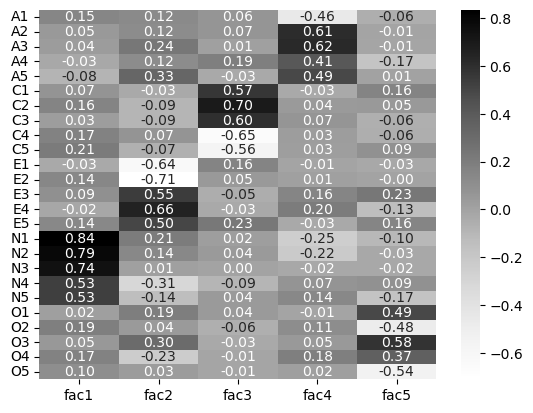

In [13]:
# Visualise heatmap
sns.heatmap(big5_loadings, 
            cmap='Greys', # Greyscale colour, so black-to-white
            annot=True, # Labels with the actual correlation
            fmt='.2f') # Tells the label to be 2 decimal places

This is an interesting result. We can see now, clearly, the existence of the factors. For example, `fac1` has high loadings with the five "N" questions, indicating it to be Neuroticism. Similarly, `fac2` has high loadings on the "E" questions, suggesting Extraversion, and so on. Notice some of the other correlations within the factors are relatively high with other types of questions too - its never a clear cut solution.

We can examine our factor variances:

In [14]:
# Show factor variances
big5_efa.get_factor_variance()

(array([2.70387986, 2.48623235, 2.04986716, 1.63844108, 1.46150922]),
 array([0.10815519, 0.09944929, 0.08199469, 0.06553764, 0.05846037]),
 array([0.10815519, 0.20760449, 0.28959917, 0.35513682, 0.41359719]))

So taken together, all factors capture about half the variance in the data. The first factor (which we think is Neuroticism...!) explains about 10%, the second, Extraversion, explains about 9%, and so on. 

What about the communalities? Do any of these indicate anything noteworthy? Again here it is helpful to visualise these.

<Axes: >

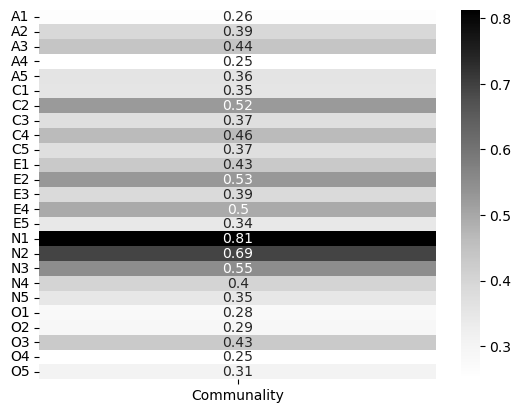

In [15]:
# Visualise communalities
comms = pd.DataFrame(big5_efa.get_communalities(), index=bf3.columns, columns=['Communality'])

# Show
sns.heatmap(comms, cmap='Greys', annot=True)

Thse don't look *too* bad. There are no hard and fast rules about what's good here, other than higher is better. Some of these like A4 and O4 may raise some eyebrows, but in general these would be acceptable. EFA is more an art than a science!


Its now possible to go one step further and examine the correlations amongst the factors themselves! That is, are the personality traits themselves correlated? This is only possible because we let `FactorAnalyzer` allow them to be correlated - there are many factor analysis approaches that produce completely uncorrelated factors, but as a rule, correlated factors make sense. These are stored in the `.phi_` attribute of the model.

In [16]:
# Get correlations of all factors
factor_corrs = big5_efa.phi_

# Tidy it up into a DataFrame, with the suspected names of the factors
factor_corrs = pd.DataFrame(factor_corrs, 
                            columns=['neuro', 'extra', 'consci', 'agree', 'open'],
                            index=['neuro', 'extra', 'consci', 'agree', 'open'])

factor_corrs

,neuro,extra,consci,agree,open
neuro,1.000000,-0.256314,0.398860,0.142306,0.345106
extra,-0.256314,1.000000,-0.224364,0.040343,-0.013000
consci,0.398860,-0.224364,1.000000,0.191999,0.236255
agree,0.142306,0.040343,0.191999,1.000000,0.155367
open,0.345106,-0.013000,0.236255,0.155367,1.000000


Neurotic people are less extraverted but more conscientious, for example. Finally, we can give each person a score on the factors too, by extracting the latent variable score for each person. This would be useful to actually score someones Big 5 traits in terms of the latent variable.

In [17]:
# Extract the scores
traits = big5_efa.transform(bf3)

# Into a dataframe
traits = pd.DataFrame(traits,
                      columns=['neuro', 'extra', 'consci', 'agree', 'open'])

# show traits
traits.head(10)

,neuro,extra,consci,agree,open
0,-0.368754,-0.298491,-1.324973,-0.917815,-1.661550
1,0.081186,0.352849,-0.535773,-0.176275,-0.278700
2,0.496539,0.106411,-0.047870,-0.658264,0.194505
3,-0.136226,-0.169679,-1.040085,-0.115630,-1.110601
4,-0.369298,0.230058,-0.101516,-0.810210,-0.725543
5,0.016293,1.238686,1.446943,0.204831,0.469544
6,-1.188218,0.204278,0.182627,0.137170,0.776679
7,0.547863,-1.806800,-1.227558,-2.100190,-0.616149
8,0.742044,0.847145,1.193344,0.391977,0.263996
9,-0.188935,0.247622,-0.144489,-0.078716,-0.329985


As an example, participant 5 has some particularly high scores on extrversion and conscientiousness, while participant 0 has rather low openness.

### But **how** many factors are there?!
We come now to the crux of EFA, and a point that causes dramatic discussion in the academic literature. For example you may have heard of the HEXACO model of personality (six factors) as opposed to the Big 5 - the same kinds of data can produce different numbers of factors. How do we choose the number of factors to extract? In the above examples we had a good theoretical grounding that guided us, but often times we are using EFA in an *exploratory* sense, that is, to explore the possible latent variables in the data.

There are many, many techniques for determining the number of factors in a dataset, and all of them come with caveats and controversy. This is - and has been for decades - an active area of research in statistics. We will look at one technique here which does reasonably well at identifying the "right" number of factors, and has a sensible philosophical background, called *parallel analysis*.

How it works is technical, but the basic idea goes like this:

1. Looking at the data you have collected, create a set of randomly-generated data that is the same number of rows and columns that is basically entirely uncorrelated.
2. Conduct a factor analysis on this created data, with the number of factors set to the number of variables (e.g. if 10 variables, get 10 factors), and calculate the 'eigenvalues' - these represent how much variance each factor explains.
3. Repeat step 2 thousands of times and collect all the variances explained for each factor.
4. Now in your real data, conducted the factor analysis with the number of factors equal to the number of variables. Get the variances explained.
5. Find where the variances in your actual data are *above and beyond* those seen from step 3. Count along until the variances of the real data *are within the bounds* of those at step 3. The number of factors up to that point is a good guess of how many factors there are, simply because beyond that the values are consistent with *entirely made up nonsense data!*

That sounds complicated, but its really using the idea of what you'd expect to see by chance as a way to understand what you see your data. Fortunately, conducting it in Python is very simple.

We use the `parallel_analysis` function from the `horns` package. We specify the analysis type as 'fa' (this approach also works for other types of analyses in this domain, like principal components analysis, so we are explicit to tell it we want an EFA), ask for the full output, and we have to convert our DataFrame to a `numpy` array. We also limit it to 500 repeats, as more take longer!

Its as simple as the below:

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested

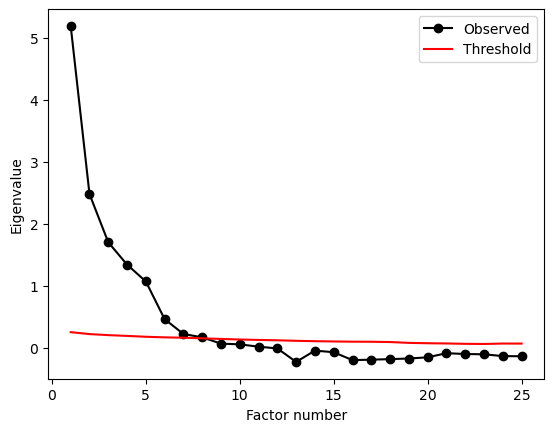

In [18]:
# Import
from horns import parallel_analysis

# Conduct
pa_results = parallel_analysis(bf3.to_numpy(), simulations=500, analysis_type='fa', full_output=True)

Parallel analysis returns a plot and a dictionary of results. The plot shows the cutoff points at which number of factors are most 'surprising' given a dataset of this size and shape. We can access the number of factors as follows:

In [19]:
# Print number of factors
print(pa_results['factors'])

8


So despite us selecting out 5, parallel analysis suggests there *eight* latent factors in the data! 

EFA is as much an art as it is a science (much like other forms of modelling), so take care when conducting it. Blindly following one approach (like top-down theory) or another (bottom-up approaches like parallel analysis) can lead you astray. To finish, let's see what an 8-factor solution of personality looks like:

<Axes: >

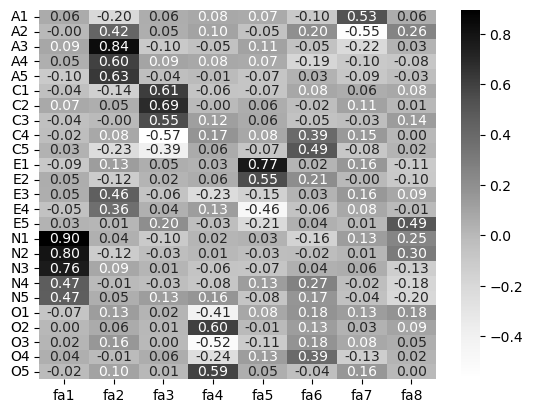

In [20]:
# 8 factors
big8_efa = FactorAnalyzer(n_factors=8).fit(bf3)

# Examine the loadings
loadings_8 = pd.DataFrame(big8_efa.loadings_, index=bf3.columns, columns=['fa1', 'fa2', 'fa3', 'fa4', 'fa5', 'fa6', 'fa7', 'fa8'])

# Heatmap
sns.heatmap(loadings_8, cmap='Greys', annot=True, fmt='.2f')

Notice here that while traits like Neuroticism and Openness orrelate with one factor (number 1 and 4 respectively), there are 'dilutions' of other traits across factors - Extraversion is spread across factors 2 and 5, and some aspects of it onto factor 8. This would be a cause for concern for psychometricians hoping for a neat set of questions measuring 5 latent factors and might result in a re-thinking of certain questions. 